# Crimeless: Static Model

<img src="img/243856847_dfd7b10570_b.jpg">


Can we predict the most dangerous areas in Boston from publicly available data? This is the question that we set out to answer by comparing a variety of datasets to a comprehensive list of geo-tagged crime scores. In this notebook we are essentially attempting to use static features to predict the Danger Score calculated in the static data notebook for a given area.

The static datasets analyzed include liquor licenses, property values, and street lights. 

We used the following models: 
* SVM
* Logistic Regression
* Linear Regression
* Naive Bayes

In [24]:
%matplotlib inline
import numpy as np
import time
import csv
import pickle
import matplotlib.pyplot as plt 

First we import and open the feature and danger dictionaries created in the static data notebook. 

In [38]:
featureDictInput = open('featureDict.pkl', 'rb')
featureDict = pickle.load(featureDictInput)

In [39]:
dangerDictInput = open('dangerDict.pkl', 'rb')
dangerDict = pickle.load(dangerDictInput)

Here we proceed to find and delete the two geotagged locations that occur in danger dictionary but not in the feature dictionary.

In [40]:
missingKeys = []
for key in dangerDict:
    if key not in featureDict:
        missingKeys.append(key)

print missingKeys
        
for k in missingKeys:
    del dangerDict[k]

[(42.32, -70.96), (42.31, -70.97)]


Next, we split the features and the danger scores into their respective X and Y arrays for the purposes of executing the models. We keep track of any problems with a count.

In [90]:
X = []
Y = []
count = 0
for key in dangerDict.keys():
    try:
        X.append(featureDict[key])
        Y.append(dangerDict[key])
    except:
        count += 1
print count

0


We then proceed to look at how strongly each feature is correlated with crime. We also plot a scatter plot of each feature against the danger scores.

In [89]:
propValues = map(lambda x: x[0], X)
liquorValues = map(lambda x: x[1], X)
streetlightValues = map(lambda x: x[2], X)
print "the correlation between property values and danger score is : ", np.corrcoef(propValues, Y)
print "the correlation between liquor licenses and danger score is : ", np.corrcoef(liquorValues, Y)
print "the correlation between streetlights and danger score is : ", np.corrcoef(streetlightValues, Y)

the correlation between property values and danger score is :  [[ 1.        -0.2281024]
 [-0.2281024  1.       ]]
the correlation between liquor licenses and danger score is :  [[ 1.          0.36892885]
 [ 0.36892885  1.        ]]
the correlation between streetlights and danger score is :  [[ 1.          0.76306557]
 [ 0.76306557  1.        ]]


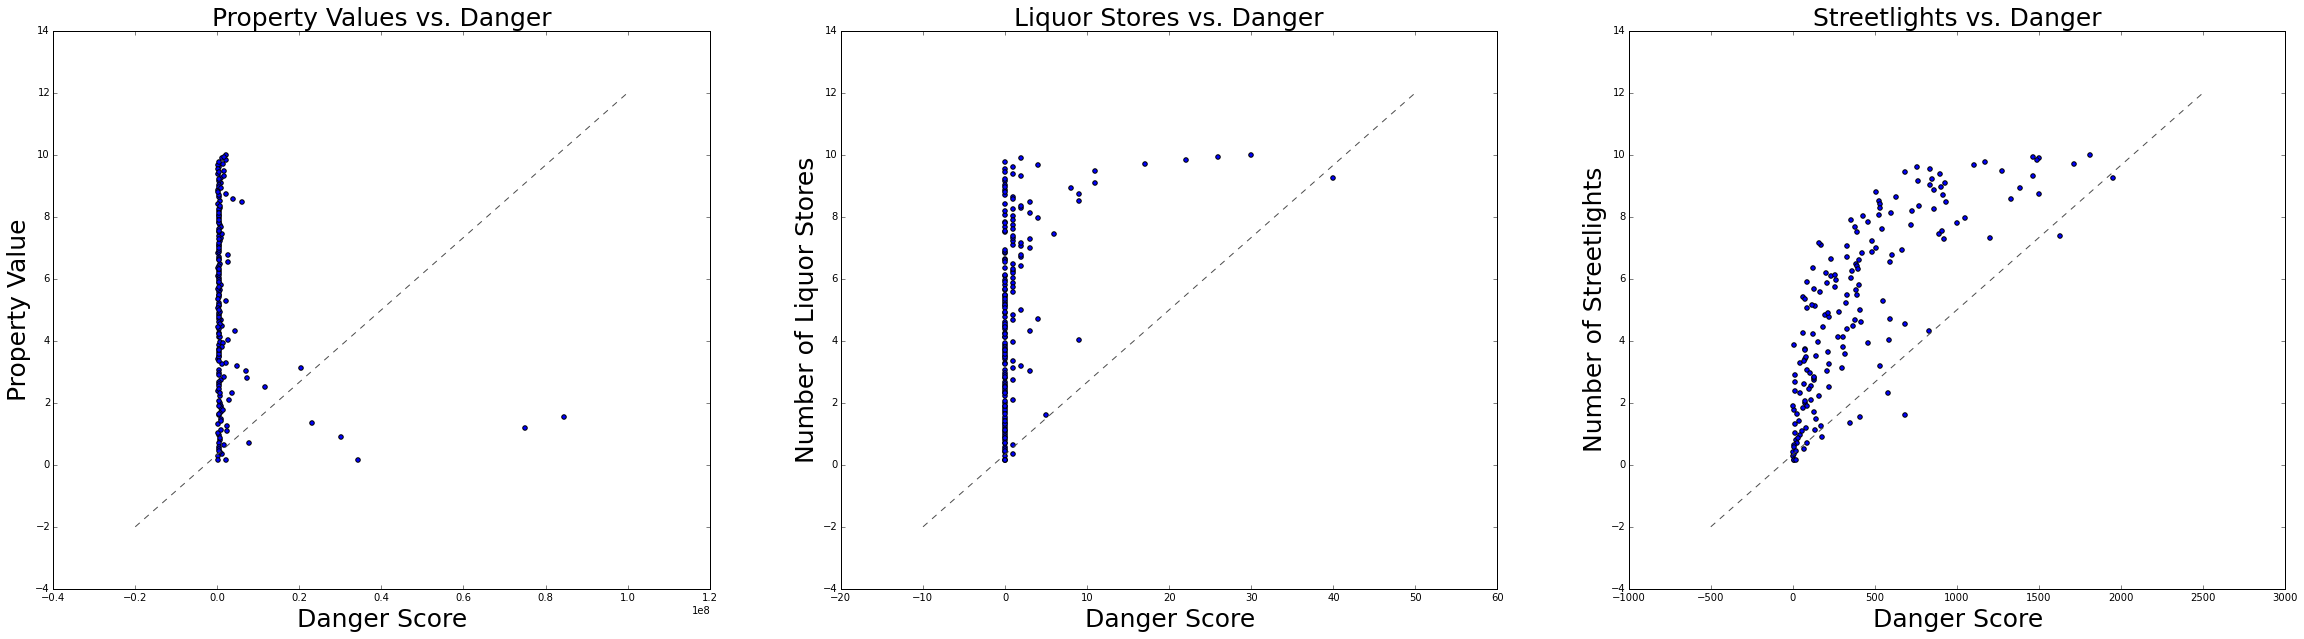

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(40, 10))
axes[0].scatter(propValues,Y)
diag_line, = axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c=".3")
axes[0].set_ylabel('Property Value',fontsize=25)
axes[0].set_xlabel('Danger Score', fontsize =25)
axes[0].set_title('Property Values vs. Danger',fontsize=25)
axes[1].scatter(liquorValues,Y)
diag_line, = axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c=".3")
axes[1].set_ylabel('Number of Liquor Stores',fontsize=25)
axes[1].set_xlabel('Danger Score', fontsize =25)
axes[1].set_title('Liquor Stores vs. Danger',fontsize=25)
axes[2].scatter(streetlightValues,Y)
axes[2].set_ylabel('Number of Streetlights',fontsize=25)
axes[2].set_xlabel('Danger Score', fontsize =25)
axes[2].set_title('Streetlights vs. Danger',fontsize=25)
diag_line, = axes[2].plot(axes[2].get_xlim(), axes[2].get_ylim(), ls="--", c=".3")

Streetlights seem to show the strongest correlation. A greater number of streetlights is associated with an increased danger score. This may be due to the fact that more populated areas have more streetlights and also more crime. Property values seem to show a very weak negative correlation with crime, which would be expected. Also, areas with more liquor stores show a greater assocation with crime. 

We split into training and test sets. Approximately 70% of the data is used for the training and 30% is used for the test. 

In [42]:
X_train = X[:120]
Y_train = Y[:120]
X_test = X[120:]
Y_test = Y[120:]

We also write a function to keep track of our error rate from each respective model's predictions. __The error rate is the average difference between our predicted danger scores and the actual danger scores from the test set.__

We chose to use this metric for determining the efficacy of our models because of the nature of the danger scores we are calculating. These scores are from 0-10, so an accuracy score of when we exactly match the correct value is less valuable here. Instead, it is helpful to know when we are closest to the actual danger scores.

In [43]:
def getErrorRate(Preds, Labels):
    errors = []
    for i in xrange(len(Preds)): 
        errors.append(np.absolute(float(Labels[i]) - float(Preds[i])))
    return float(sum(errors))/len(errors)

We can run this code in case we wish to switch between continuous data (with a decimal) and labelled data (integers).  

In [45]:
Y_train= map(lambda x: round(x, 0), Y_train)
Y_test = map(lambda x: round(x, 0), Y_test)
Y = map(lambda x: round(x, 0), Y)

## SVM

We set up a classifier using SVC. We then fit the classifier SVM on the training data. We use GridSearchCV over a parameter grid of regularization coefficients (stored in the Cs array) to find the best fit classifier. We use 5-fold cross validation. This will help us find the best value of C to use. We then fit the data again with this best classifier and find the number of errors from the resulting predicitons.

In [140]:
from sklearn.svm import SVC
clfsvm = SVC()
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

from sklearn.grid_search import GridSearchCV

parameters = {"C": Cs}
fitmodel = GridSearchCV(clfsvm, param_grid = parameters, cv = 5)
fitmodel.fit(X_train, Y_train)
print "The best parameter is:", fitmodel.best_params_
best = fitmodel.best_estimator_
best.fit(X_train,Y_train)
SCMpredictions = best.predict(X_test)
getErrorRate(SCMpredictions, Y_test)

The best parameter is: {'C': 0.001}


2.6666666666666665

In [141]:
clfsvm.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [142]:
SVMPredictions = clfsvm.predict(X_test)

In [143]:
SVMPredictions

array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.])

Unfortunately the SVM predicts a 4 at every location.

In [144]:
getErrorRate(SVMPredictions, Y_test)

2.6666666666666665

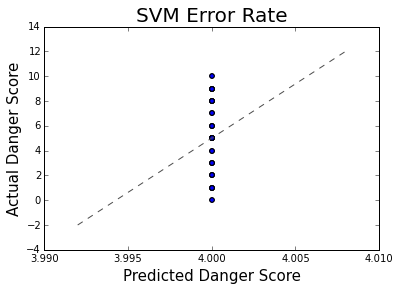

In [145]:
f, ax = plt.subplots()
plt.scatter(SVMPredictions,Y_test)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylabel('Actual Danger Score',fontsize=15)
ax.set_xlabel('Predicted Danger Score', fontsize =15)
ax.set_title('SVM Error Rate',fontsize=20)

We obtain this poor result because at 174 samples we have a very small sample size and SVM tends to perform better with very large datasets. 

## Logistic Regression

Next, we proceed to fit a logistic regression in the same manner as we did with the SVM.

In [54]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()
logReg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [57]:
logRegPreds = logReg.predict(X_test)

In [58]:
logRegPreds

array([ 9.,  1.,  4.,  4.,  4.,  7.,  4.,  9.,  3.,  7.,  9.,  9.,  3.,
        4.,  4.,  3.,  9.,  9.,  3.,  4.,  9.,  3.,  4.,  3.,  9.,  7.,
        4.,  3.,  7.,  9.,  4.,  9.,  4.,  4.,  7.,  4.,  4.,  7.,  4.,
        4.,  7.,  4.,  3.,  9.,  1.,  7.,  7.,  7.,  4.,  3.,  3.,  4.,
        7.,  3.])

In [59]:
getErrorRate(logRegPreds, Y)

3.314814814814815

In [60]:
def cv_optimize(clf, parameters, X, y, n_folds, score_func = None):
    fitmodel = GridSearchCV(clf, param_grid = parameters, cv = n_folds, scoring = score_func)
    fitmodel.fit(X, y)
    return fitmodel.best_estimator_

In [61]:
reuse_split=dict(Xtrain=X_train, Xtest=X_test, ytrain=Y_train, ytest=Y_test)

In [62]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, X,Y, featurenames, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    X=X
    y=Y
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [137]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression(penalty = "l1")
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clflog, {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, X_train, Y_train, u'RESP',1, reuse_split = reuse_split)

using reuse split
############# based on standard predict ################
Accuracy on training data: 0.40
Accuracy on test data:     0.26
[[0 1 0 1 0 0 0 0 0 0 0]
 [0 1 0 3 1 0 1 0 0 0 0]
 [0 1 0 3 0 0 1 0 0 0 0]
 [0 2 0 2 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0 0]
 [0 0 0 1 3 0 4 1 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 3 3 0 0]
 [0 0 0 0 0 0 0 2 3 1 1]
 [0 0 0 0 0 0 0 0 0 2 0]]
########################################################


As stated above, this low accuracy is not indicative of the performance of our model due to the nature of our data. Since we are attempting to create danger scores, it is more informative to look at how much the predicted values deviated from the actual danger scores (as shown in the error rate plot below). 

In [139]:
logpreds = clflog.predict(Xtest)
getErrorRate(logpreds, Y)

3.2781986531986527

Our error rate is only slightly lower than before, so optimizing did not have a large effect. The error rate is also worse than the SVM model's predictions.

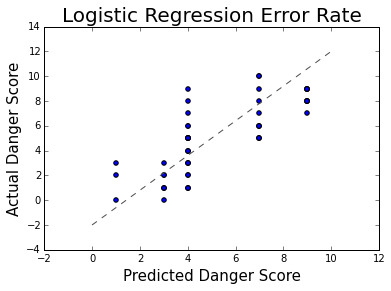

In [130]:
f, ax = plt.subplots()
plt.scatter(logpreds,Y_test)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylabel('Actual Danger Score',fontsize=15)
ax.set_xlabel('Predicted Danger Score', fontsize =15)
ax.set_title('Logistic Regression Error Rate',fontsize=20)

## Linear Regression

Next, we implement a linear regression:

In [66]:
from sklearn.linear_model import LinearRegression
linReg = LinearRegression()
linReg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
linRegPreds = linReg.predict(X_test)
linRegPreds = map(lambda x: max(0, x), linRegPreds)

In [74]:
getErrorRate(linRegPreds, Y_test)

1.3014078929862036

This error rate is signifcantly lower than the previous models. 

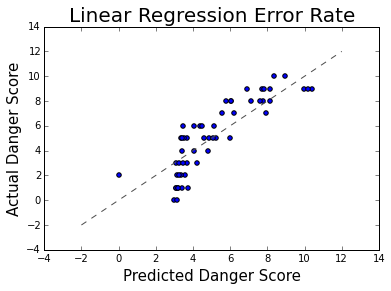

In [131]:
f, ax = plt.subplots()
plt.scatter(linRegPreds,Y_test)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylabel('Actual Danger Score',fontsize=15)
ax.set_xlabel('Predicted Danger Score', fontsize =15)
ax.set_title('Linear Regression Error Rate',fontsize=20)

The error rate plot also shows the efficacy of the linear regression model. 

## Naive Bayes

Finally, we use the Naive Bayes classification algorithm. 

In [75]:
Y_train_labels = map(lambda x: round(x, 0), Y_train)
Y_test_labels = map(lambda x: round(x, 0), Y_test)
Y_labels = map(lambda x: round(x, 0), Y)

In [76]:
from sklearn.naive_bayes import GaussianNB
naiveBayes = GaussianNB()
naiveBayes.fit(X_train, Y_train_labels)

GaussianNB()

In [77]:
NBPreds = naiveBayes.predict(X_test)

In [78]:
getErrorRate(NBPreds, Y_labels)

3.4444444444444446

This error rate is significantly higher than the previous models. Since the features are not independent given the class label, the naive bayes algorithm performs poorly. 

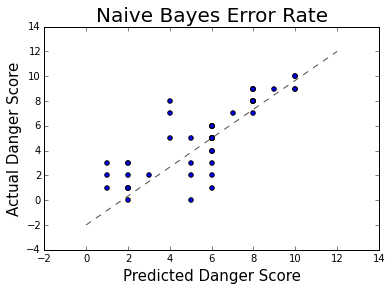

In [132]:
f, ax = plt.subplots()
plt.scatter(NBPreds,Y_test)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_ylabel('Actual Danger Score',fontsize=15)
ax.set_xlabel('Predicted Danger Score', fontsize =15)
ax.set_title('Naive Bayes Error Rate',fontsize=20)

In summary, the linear regression model does the best job predicting danger scores for a given area, with a mean error rate of only ~1.3. 

## Conclusion

In this part of our project, we set out to understand the types of static publicly available factors that were most correlated with the number and severity of crimes an area focused (parameters we condensed into a “danger” rating). We used variables such as property values, the number of liquor stores and the amount of streetlights in a given area to try and understand which factors were most related to the danger score of each area, and then trained regressions and classifiers over these factors to get a predicted danger score for each location. 

We found that the amount of streetlights was highly positively correlated with the danger index, which is perhaps not surprising given that streetlights are likely more heavily concentrated in densely populated areas. Out of our machine learning techniques, Linear Regression actually did the best job assigning a score to each area and had an average error of 1.3, which means that for a given danger score from 1 to 10 it was off by 13% on average. This is actually not bad at all given that our target space is not binary but rather can be one of ten different buckets and so we are very pleased with the results of this section.